In [9]:
%cd ../RADOM
from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [10]:
import pandas as pd
import numpy as np

## mESC

Amadei dataset. (mouse embryos).

In [43]:
data_dir = '/home/ggorin/count_data/amadei/'

In [44]:
names = ['NE{}_{}'.format(x,str(y)) for x in ['65','75'] for y in range(1,3)]+['NE85_{}'.format(str(x)) for x in range(1,7)]

In [48]:
import xlrd
xlrd.xlsx.ensure_elementtree_imported(False, None)
xlrd.xlsx.Element_has_iter = True

In [49]:
meta = pd.read_excel(data_dir+'meta.xlsx')

/tmp/ipykernel_1396580/3630299904.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  meta = pd.read_excel(data_dir+'meta.xlsx')


In [53]:
meta.set_index('barcode')

,celltype,latent_time,type,UMAP_1,UMAP_2
barcode,,,,,
AAACACGGTGGTAACGCCGTGTTT,Epiblast,0.524328,Synthetic,-0.249567,0.602579
AAACACGGTGGTAACGGACAACTT,Gut precursors,0.877421,Synthetic,13.514733,0.282939
AAACACTATGGTAACGCAGTTTGC,Epiblast,0.501554,Synthetic,-2.048857,-0.758087
AAACTGTGTGGTAACGTCCCGTAG,Epiblast,0.611674,Synthetic,1.404837,1.976268
AAAGAAAGTGGTAACGAATCGGGT,Definitive endoderm,0.439383,Synthetic,-1.234815,-5.289140
...,...,...,...,...,...
TGCACCAGCTTGCAGATGTGGCTA,Epiblast,0.039232,natural,NaN,NaN
TGCGACTACTTGCAGAGGTGACAC,Epiblast,0.094287,natural,NaN,NaN
TGGACGGACTTGCAGAATCCCACG,Definitive endoderm,0.314687,natural,NaN,NaN


In [69]:
meta_bcs = meta['barcode']

In [90]:
meta_bcs_natural = meta['barcode'][meta['type']=='natural']

In [95]:
print(f'{len(meta_bcs)} annotated barcodes.\n')
print(f'{len(meta_bcs_natural)} annotated natural barcodes.\n')

data_bcs_all = []
for data_ind, dataset in enumerate(names):
    print(f'Dataset: {dataset}')
    data_str = '/home/ggorin/count_data/amadei/{}.inex.txt'.format(dataset)
    df = pd.read_csv(data_str,sep='\t',nrows = 1 )
    data_bcs = df.columns.str[-24:]
    print(f'\t{len(data_bcs)} barcodes.')
    data_bcs_in_meta = data_bcs[data_bcs.isin(meta_bcs)]
    print(f'\t{len(data_bcs_in_meta)} are in metadata.')
    data_bcs_all.append(data_bcs_in_meta)
data_bcs_all = np.concatenate(data_bcs_all)
print(f'{len(data_bcs_all)} total data barcodes in metadata.')
print(f'{len(np.unique(data_bcs_all))} are unique.')
data_bcs_in_meta = data_bcs_all[pd.Series(data_bcs_all).isin(meta_bcs_natural)]
print(f'{len(data_bcs_in_meta)} are labeled as natural in metadata.')


5419 annotated barcodes.

2653 annotated natural barcodes.

Dataset: NE65_1
	3312 barcodes.
	157 are in metadata.
Dataset: NE65_2
	2442 barcodes.
	104 are in metadata.
Dataset: NE75_1
	6250 barcodes.
	806 are in metadata.
Dataset: NE75_2
	8455 barcodes.
	548 are in metadata.
Dataset: NE85_1
	11875 barcodes.
	116 are in metadata.
Dataset: NE85_2
	9122 barcodes.
	561 are in metadata.
Dataset: NE85_3
	12397 barcodes.
	14 are in metadata.
Dataset: NE85_4
	11662 barcodes.
	84 are in metadata.
Dataset: NE85_5
	11737 barcodes.
	241 are in metadata.
Dataset: NE85_6
	12596 barcodes.
	101 are in metadata.
2732 total data barcodes in metadata.
2732 are unique.
2597 are labeled as natural in metadata.


## MEFs

Schiebinger et al., 2019. Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.

Reprogramming of secondary MEFs to iPSCs.

We use their time course experiment data (GSE115943) collected at 39 time points across 18 days (~250,000 cells).

Specifically, we extract following samples ('D75_Dox_C1' 'D8_Dox_C1' 'D825_serum_C1' 'D85_serum_C1' 'D875_serum_C1' 'D9_serum_C1' 'D95_serum_C1') to model the transition from phase 1 to phase 2.

In [45]:
import scanpy as sc
import anndata as ad
import h5py 

In [12]:
data_dir = '/home/ggorin/count_data/poisson_regression/schiebinger/'

In [17]:
f = h5py.File(data_dir+'D95_serum_C1.h5','r')
f.keys()

<KeysViewHDF5 ['mm10']>

In [14]:
f['mm10'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'gene_names', 'genes', 'indices', 'indptr', 'shape']>

In [4]:
f['mm10']['data']

<HDF5 dataset "data": shape (2577781,), type "<i4">

In [5]:
f['mm10']['indices'][:10]

array([27994, 27920, 27917, 27916, 27915, 27914, 27913, 27911, 27910,
       27909])

In [12]:

np.savetxt('/home/ggorin/datasets/schiebinger/b2f/D95_serum_C1/whitelist.txt', \
           np.asarray([x[:-2] for x in f['mm10']['barcodes']],dtype=str),fmt='%16s')


In [7]:
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')
for d in DATASET_NAMES:
    f = h5py.File('/home/ggorin/count_data/schiebinger/{}.h5'.format(d),'r')
    np.savetxt('/home/ggorin/datasets/schiebinger/b2f/{}/whitelist.txt'.format(d), \
               np.asarray([x[:-2] for x in f['mm10']['barcodes']],dtype=str),fmt='%16s')


In [18]:
import loompy as lp

In [24]:
attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
with lp.connect(data_dir+'D95_serum_C1/counts_unfiltered/adata.loom', mode="r") as ds:
    layers = [ds.layers[layer][:] for layer in layer_names]
    gene_names = ds.ra[gene_attr]
    barcodes = ds.ca[cell_attr]


In [26]:
gene_names

array(['AC125149.3', 'AC125149.1', 'AC125149.4', ..., 'Gm37998',
       'Gm37263', 'Gm37286'], dtype=object)

In [21]:
len(barcodes)

1156

In [22]:
layers = np.asarray(layers,dtype=int)

In [23]:
layers.shape

(2, 32285, 1156)

In [22]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'spliced')

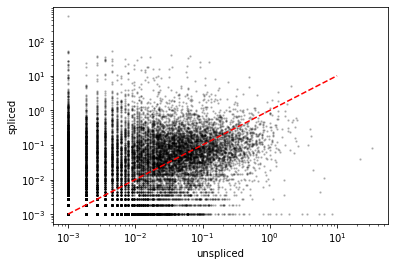

In [37]:
mean_exp = layers.mean(2)
eps=1e-3
plt.scatter(mean_exp[0]+eps,mean_exp[1]+eps,2,'k',alpha=0.2)
xl=[1e-3,1e1]
plt.plot(xl,xl,'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('unspliced')
plt.ylabel('spliced')

In [36]:
(mean_exp[0]>mean_exp[1]).sum()

8272

In [38]:
layers

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

D75_Dox_C1: 2591 cells.
D8_Dox_C1: 1879 cells.
D825_serum_C1: 1549 cells.
D85_serum_C1: 1654 cells.
D875_serum_C1: 1616 cells.
D9_serum_C1: 1842 cells.
D95_serum_C1: 1156 cells.


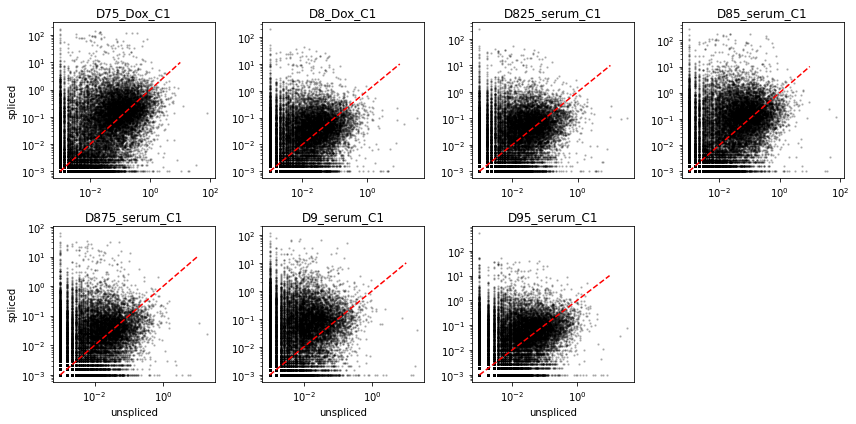

In [51]:
attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')

fig1,ax1=plt.subplots(2,4,figsize=(12,6))
for k,d in enumerate(DATASET_NAMES):
    axloc = np.unravel_index(k,(2,4))
    
    with lp.connect('/home/ggorin/count_data/schiebinger/{}/counts_unfiltered/adata.loom'.format(d), mode="r") as ds:
        layers = [ds.layers[layer][:] for layer in layer_names]
        gene_names = ds.ra[gene_attr]
        barcodes = ds.ca[cell_attr]
    layers = np.asarray(layers,dtype=int)
    mean_exp = layers.mean(2)
    eps=1e-3
    ax1[axloc].scatter(mean_exp[0]+eps,mean_exp[1]+eps,2,'k',alpha=0.2)
    xl=[1e-3,1e1]
    ax1[axloc].plot(xl,xl,'r--')
    ax1[axloc].set_xscale('log')
    ax1[axloc].set_yscale('log')
    if axloc[0]>0:
        ax1[axloc].set_xlabel('unspliced')
    if axloc[1]==0:
        ax1[axloc].set_ylabel('spliced')
    ax1[axloc].set_title(d)
    print(f'{d}: {len(barcodes)} cells.')
plt.delaxes(ax1[1,3])
fig1.tight_layout()


### Prepare input data

#### Concatenate data matrices at different time points

In [59]:
attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')
DATASET_TIME = (7.5,8,8.25,8.5,8.75,9,9.5)

Data = None
gene_names = None
barcodes = []
time = []
for k,d in enumerate(DATASET_NAMES):
    with lp.connect(data_dir+'{}/counts_unfiltered/adata.loom'.format(d), mode="r") as ds:
        layers = [ds.layers[layer][:] for layer in layer_names]
        
        ## Check gene_names are the same
        if gene_names is None:
            gene_names = ds.ra[gene_attr]
        else:
            assert(np.all(gene_names == ds.ra[gene_attr]))
            
        ## Append counts
        if Data is None:
            Data = np.asarray(layers,dtype=int).T
            n = len(Data)
        else:
            data = np.asarray(layers,dtype=int).T
            n = len(data)
            Data = np.append(Data, data, axis=0)
            
        ## Add cell barcodes and cell times
        barcodes.append(ds.ca[cell_attr])
        time.append(np.repeat(DATASET_TIME[k],n))
        
barcodes = np.concatenate(barcodes).ravel()
time = np.concatenate(time).ravel()

In [71]:
adata = ad.AnnData(Data.sum(axis=-1))
adata.layers["unspliced"]=Data[:,:,0]
adata.layers["spliced"]=Data[:,:,1]
adata.obs["barcode"]=barcodes
adata.obs["time"]=time
adata.var["genes"]=gene_names
adata

AnnData object with n_obs × n_vars = 12287 × 32285
    obs: 'barcode', 'time'
    var: 'genes'
    layers: 'unspliced', 'spliced'

In [74]:
adata.write_loom('../data/MEF.loom')

#### Select genes and get the input matrix

In [103]:
adata = ad.read_loom('../data/MEF.loom')

Genes are selected according to their [Table S2](https://www.cell.com/cms/10.1016/j.cell.2019.01.006/attachment/a687e497-b4c8-45a3-b786-b59db5f3b9d0/mmc2.xlsx) (List of Genes Comprising Gene Signatures, Related to Figures 2, 3, 4, and 5) 


In [29]:
selected_genes = ["Sox2", "Oct4", "Klf4", "Myc","Vtn","Ednrb","Sox21",'Zeb2',
                  'Hes5','Fabp7','Sox1','Neurod1','Pax3','Pax6','Cdh2','Sox9','Sox2',
                  'Id2','Hoxb1','Msx1','Msi1','Msi2','Atoh1','Rbfox3','Map2','Tubb3']

In [116]:
selected_genes = ["Sox2", "Oct4", "Klf4", "Myc",'Rarb', 'Foxp2', 'Emx1', 'Pou3f2', 'Nr2f1', 'Myt1l', 
                  'Neurod4', 'Scrt2', 'Nhlh2', 'Pou2f2','Onecut1', 'Tal2', 'Barhl1', 'Pitx2','Msx1','Msx3']

In [117]:
idx = [np.where(gene_names==gene)[0] for gene in selected_genes]
idx = np.concatenate(idx).ravel()
gene_names[idx]

array(['Sox2', 'Klf4', 'Myc', 'Rarb', 'Foxp2', 'Emx1', 'Pou3f2', 'Nr2f1',
       'Myt1l', 'Neurod4', 'Scrt2', 'Nhlh2', 'Pou2f2', 'Onecut1', 'Tal2',
       'Barhl1', 'Pitx2', 'Msx1', 'Msx3'], dtype=object)

In [118]:
n,p = adata[:,idx].X.shape
X = np.zeros((n,p,2))
X[:,:,0]= adata.layers["unspliced"].toarray()[:,idx]
X[:,:,1]= adata.layers["spliced"].toarray()[:,idx]
X.shape

(12287, 19, 2)

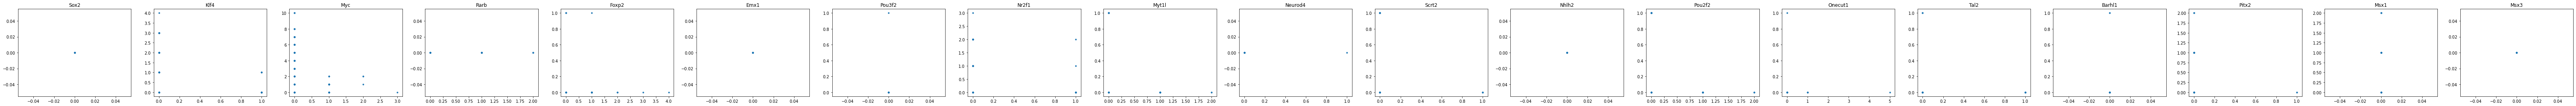

In [119]:
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(gene_names[idx[j]])

### Fitting

In [92]:
topo = np.array([[0,]])
tau = (0,48) # ~48 hours
traj = Trajectory(topo, tau)

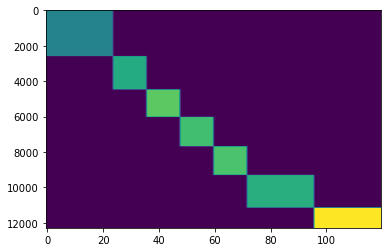

In [96]:
n, p, _ = X.shape
m = 120
DATASET_TIME = (7.5, 8,  8.25, 8.5, 8.75, 9,  9.5)
time_indices = [0,   24, 36,   48,  60,   72, 96, 120]
Q = np.zeros((n,1,m))
for i,t in enumerate(DATASET_TIME):
    cell_idx = np.where(time == t)
    Q[cell_idx,0,time_indices[i]:time_indices[i+1]]=1
Q = Q/np.sum(Q,axis=0,keepdims=True)
plt.imshow(Q[:,0],aspect='auto')

In [100]:
res = traj.fit(X,Q=Q,parallel=True,n_threads=10)

run method fit_warm_start


 40%|████      | 8/20 [00:19<00:29,  2.47s/it]


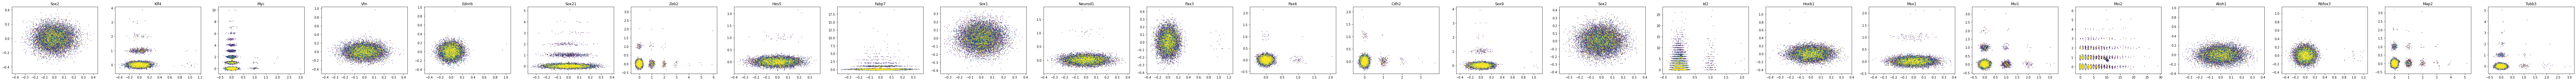

In [111]:
plot_phase(X,Q,traj,idx=np.arange(p),gene_name=gene_names[idx])

## Lange pancreas


CellRank.

In [52]:
import anndata as ad

In [57]:
adata_raw = ad.read_h5ad('/home/ggorin/count_data/poisson_regression/lange/endocrinogenesis_day15.5.h5ad','r')

In [58]:
adata_pre = ad.read_h5ad('/home/ggorin/count_data/poisson_regression/lange/endocrinogenesis_day15.5_preprocessed.h5ad','r')

In [60]:
adata_raw

AnnData object with n_obs × n_vars = 2531 × 27998 backed at '/home/ggorin/count_data/poisson_regression/lange/endocrinogenesis_day15.5.h5ad'
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [61]:
adata_pre

AnnData object with n_obs × n_vars = 2531 × 2000 backed at '/home/ggorin/count_data/poisson_regression/lange/endocrinogenesis_day15.5_preprocessed.h5ad'
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: '

In [66]:
adata_pre.layers['spliced'][:10,:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.3840294 ],
        [1.120772  , 0.        , 1.120772  , 0.        , 0.        ,
         1.120772  , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.61589766,
         0.        , 0.        , 0.        , 0.61589766, 0.        ],
        [1.0937865 , 0.        , 0.        , 1.0937865 , 0.        ,
         0.        , 0.        , 2.187573  , 0.        , 0.        ],
        [0.        , 0.        , 0.8843014 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.6134829 , 0.6134829 ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [68]:
adata_raw.layers['spliced'][:30,:30].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 2., 1., 0., 0., 0., 0., 0., 3., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.

In [69]:
adata_pre.obs['clusters']

index
AAACCTGAGAGGGATA-1-3            Fev+
AAACCTGAGGCAATTA-1-3           Alpha
AAACCTGGTAAGTGGC-1-3    Ngn3 high EP
AAACCTGTCCCTCTTT-1-3           Alpha
AAACGGGAGTAGCGGT-1-3           Delta
                            ...     
TTTGGTTTCCTTTCGG-1-3            Beta
TTTGTCAAGAATGTGT-1-3            Fev+
TTTGTCAAGTGACATA-1-3            Fev+
TTTGTCATCGAATGCT-1-3           Alpha
TTTGTCATCTGTTTGT-1-3         Epsilon
Name: clusters, Length: 2531, dtype: category
Categories (7, object): ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta', 'Alpha', 'Delta', 'Epsilon']

## Barile

In [1]:
import anndata as ad

In [7]:
adata_mouse = ad.read_h5ad('/home/ggorin/count_data/poisson_regression/barile/adata_for_velocity_mouse.h5','r')

In [8]:
adata_mouse.layers['spliced'][:10,:10].todense()

matrix([[0., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 0., 2., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 2., 3., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
adata_human  = ad.read_h5ad('/home/ggorin/count_data/poisson_regression/barile/adata_human_for_velocity.h5','r')

In [11]:
adata_human.layers['spliced'][:10,:10].todense()

matrix([[ 0,  4,  0, 20,  0,  3,  0,  1,  6,  0],
        [ 0,  2,  0, 10,  0,  6,  0,  2,  2,  0],
        [ 0,  0,  0,  4,  0,  0,  0,  2,  8,  2],
        [ 0,  1,  0,  5,  0,  0,  0,  1, 17,  0],
        [ 0,  4,  0, 31,  0,  8,  0,  0,  1,  1],
        [ 0,  0,  0,  4,  0,  2,  0,  0,  7,  0],
        [ 0,  2,  0,  4,  0,  3,  0,  0, 13,  2],
        [ 0,  6,  0, 17,  0, 14,  0,  1,  7,  0],
        [ 0,  6,  0, 47,  0, 12,  0,  0,  0,  0],
        [ 0,  6,  0, 22,  0,  9,  0,  0,  0,  0]], dtype=uint16)